# word2vec

Ten notatnik ma na celu przedstawienie sposobu tworzenia i wykorzystania reprezentacji werktorowych na przykładzie algorytmu word2vec. W trakcie zadania najpierw stworzymy prostą reprezentację wektorową, a następnie spróbujemy wczytać gotowy model nauczony na dużym korpusie tekstowym.

Po wykonaniu tego zadania powinieneś:
+ wiedzieć na czym polega word2vec,
+ potrafić stworzyć word2vec na własnych danych,
+ potrafić wykorzystać word2vec do:
	+ znalezienia podobnych słów,
	+ wyszukiwania słów na zasadzie "reguły trzech", 
	+ wykrywania niepasujących słów,
	+ do tworzenia wektora cech nadającego się do klasyfikacji,
+ wczytać i wykorzystać gotowy model.

## Prosty model

Najpierw wczytamy odpowiednie biblioteki i stworzymy mały zbiór treningowy na podstawie znanej piosenki.

In [1]:
import gensim, logging, re, nltk
import pandas as pd

RE_SPACES = re.compile("\s+")
RE_HASHTAG = re.compile("[@#][_a-z0-9]+")
RE_EMOTICONS = re.compile("(:-?\))|(:p)|(:d+)|(:-?\()|(:/)|(;-?\))|(<3)|(=\))|(\)-?:)|(:'\()|(8\))")
RE_HTTP = re.compile("http(s)?://[/\.a-z0-9]+")

# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
 
song = """Gdzie strumyk płynie z wolna,
Rozsiewa zioła maj,
Stokrotka rosła polna,
A nad nią szumiał gaj,
Stokrotka rosła polna,
A nad nią szumiał gaj,
Zielony gaj.

W tym gaju tak ponuro,
Że aż przeraża mnie,
Ptaszęta za wysoko,
A mnie samotnej źle,
Ptaszęta za wysoko,
A mnie samotnej źle,
samotnej źle.

Wtem harcerz idzie z wolna.
„Stokrotko, witam cię,
Twój urok mnie zachwyca,
Czy chcesz być mą, czy nie?”
"Twój urok mnie zachwyca,
Czy chcesz być mą, czy nie?
Czy nie, czy nie?

Stokrotka się zgodziła
I poszli w ciemny las,
A harcerz taki gapa
że aż w pokrzywy wlazł,
A harcerz taki gapa
że aż w pokrzywy wlazł,
w pokrzywy wlazł.

A ona, ona, ona,
Cóż biedna robić ma,
Nad gapą pochylona
I śmieje się: ha, ha,
Nad gapą pochylona
I śmieje: się ha, ha,
ha, ha, ha, ha."""

**Zad. 1: Podziel piosenkę na wersy, a wersy tokenizuj spacjami. W efekcie powinieneś stworzyć listę list i przypisać ją do zmiennej `sentences`.**

In [2]:
rt = nltk.tokenize.RegexpTokenizer(r'\w+')
sentences = [rt.tokenize(i.lower() )for i in song.split("\n") if len(i.split(" ")) > 1]
# sentences = [ for j in sentences for i in j]
print(sentences)
print(len(sentences))

[['gdzie', 'strumyk', 'płynie', 'z', 'wolna'], ['rozsiewa', 'zioła', 'maj'], ['stokrotka', 'rosła', 'polna'], ['a', 'nad', 'nią', 'szumiał', 'gaj'], ['stokrotka', 'rosła', 'polna'], ['a', 'nad', 'nią', 'szumiał', 'gaj'], ['zielony', 'gaj'], ['w', 'tym', 'gaju', 'tak', 'ponuro'], ['że', 'aż', 'przeraża', 'mnie'], ['ptaszęta', 'za', 'wysoko'], ['a', 'mnie', 'samotnej', 'źle'], ['ptaszęta', 'za', 'wysoko'], ['a', 'mnie', 'samotnej', 'źle'], ['samotnej', 'źle'], ['wtem', 'harcerz', 'idzie', 'z', 'wolna'], ['stokrotko', 'witam', 'cię'], ['twój', 'urok', 'mnie', 'zachwyca'], ['czy', 'chcesz', 'być', 'mą', 'czy', 'nie'], ['twój', 'urok', 'mnie', 'zachwyca'], ['czy', 'chcesz', 'być', 'mą', 'czy', 'nie'], ['czy', 'nie', 'czy', 'nie'], ['stokrotka', 'się', 'zgodziła'], ['i', 'poszli', 'w', 'ciemny', 'las'], ['a', 'harcerz', 'taki', 'gapa'], ['że', 'aż', 'w', 'pokrzywy', 'wlazł'], ['a', 'harcerz', 'taki', 'gapa'], ['że', 'aż', 'w', 'pokrzywy', 'wlazł'], ['w', 'pokrzywy', 'wlazł'], ['a', 'ona', 'o

Mając tekst podzielony na zdania a zdania na tokeny, możemy nauczyć model word2vec.

**Zad. 2: Naucz model word2vec. [Sprawdź](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) za co odpowiedzialne są parametry `min_count` i `iter`. Jakie inne parametry mogą być przydatne?**

In [3]:
# min_count (int, optional) – Ignores all words with total frequency lower than this.
# epochs (int, optional) – Number of iterations (epochs) over the corpus. (Formerly: iter)

# Inne przydatne parametry:
# * alpha (float, optional) – The initial learning rate.
# * window (int, optional) – Maximum distance between the current and predicted word within a sentence.
# * workers (int, optional) – Use these many worker threads to train the model (=faster training with multicore machines).

model = gensim.models.Word2Vec(sentences, iter=5, min_count=1)
print(model)
print(model.vocabulary)

model.wv.doesnt_match("las harcerz gaj zioła".split())

Word2Vec(vocab=64, size=100, alpha=0.025)


'gaj'

Model jest niezwykle mały i niezbyt praktyczny, ale pozwolił pokazać podstawę uczenia word2vec. Przy większych korpusach tekstowych wczytywanie do pamięci wielkich tablic nie byłoby najlepszym pomysłem. Na szczęście implementacja word2vec w gensim potrafi przetwarzać dane przyrostowo.

## Przetwarzanie strumieniowe

Zamiast wczytywać wszystkie dokumenty naraz można robić to partiami, bo sieci neuronowe (w tym word2vec) potrafią douczać się przyrostowo. Do douczania przyrostowego świetnie nada się pythonowy iterator lub generator. Jeśli nie kojarzysz na czym polega działanie iteratorów i generatorów, zobacz jak [wyjaśnia to Radim Rehurek](https://rare-technologies.com/data-streaming-in-python-generators-iterators-iterables/).

Zasymulujmy zdania/wersy/tweety przechowywane w osobnych plikach.

In [4]:
import smart_open, os

if not os.path.exists('./data/'):
    os.makedirs('./data/')

filenames = ['./data/f' + str(i) +'.txt' for i in range(35)]

if sentences is not None:
    for i, fname in enumerate(filenames):
        with smart_open.smart_open(fname, 'w') as fout:
            for line in sentences[i]:
                fout.write(line + ' ')

**Zad. 3: Mając powyższy zbiór dokumentów tekstowych, stwórz metodę która będzie "leniwie" iterowała przez zasymulowany zbiór danych. Podczas iterowania usuń znaki interpunkcyjne i zmień wszystkie litery na małe.**

In [5]:
class MySentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            if fname.endswith('.txt'):
                for line in open(os.path.join(self.dirname, fname)):
                    yield line.split(" ")

# Do odkomentowania:
sentences = MySentences('./data/')
model = gensim.models.Word2Vec(sentences, iter=10, min_count=1)
print(model)

model.wv.doesnt_match("las harcerz gaj zioła".split())

Word2Vec(vocab=65, size=100, alpha=0.025)


'gaj'

## Trochę więcej danych i przykłady zastosowań

Jak wspomniano wcześniej powyższa piosenka jest zbyt krótka by stworzyć przekonujący model podobieństwa między słowami. Przejdziemy teraz na język angielski i wykorzystamy korpus dołączony do biblioteki `gensim`. Ten korpus nie jest jeszcze duży, więc wyniki nie będą rewelacyjne. Potrzeba > 500 tys. słów, żeby oczekiwać rozsądnych wyników dla ogólnych zapytań, ale przy specjalistycznych zastosowaniach korpusy niekoniecznie muszą być takie duże.

**Zad. 4: Korzystając ze zdobytej wiedzy na temat iteratorów, uzupełnij poniższy kod.**

In [6]:
test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data']) + os.sep
lee_train_file = test_data_dir + 'lee_background.cor'

class MyText(object):
    def __iter__(self):
        for line in open(lee_train_file):
            # Załóż, że każda linia to dokument, zmień litery na małe,
            # usuń podstawowe znaki interpunkcyjne i podziel według białych znaków
            yield rt.tokenize(line.lower())

sentences = MyText()
print(list(sentences)[:1])

[['hundreds', 'of', 'people', 'have', 'been', 'forced', 'to', 'vacate', 'their', 'homes', 'in', 'the', 'southern', 'highlands', 'of', 'new', 'south', 'wales', 'as', 'strong', 'winds', 'today', 'pushed', 'a', 'huge', 'bushfire', 'towards', 'the', 'town', 'of', 'hill', 'top', 'a', 'new', 'blaze', 'near', 'goulburn', 'south', 'west', 'of', 'sydney', 'has', 'forced', 'the', 'closure', 'of', 'the', 'hume', 'highway', 'at', 'about', '4', '00pm', 'aedt', 'a', 'marked', 'deterioration', 'in', 'the', 'weather', 'as', 'a', 'storm', 'cell', 'moved', 'east', 'across', 'the', 'blue', 'mountains', 'forced', 'authorities', 'to', 'make', 'a', 'decision', 'to', 'evacuate', 'people', 'from', 'homes', 'in', 'outlying', 'streets', 'at', 'hill', 'top', 'in', 'the', 'new', 'south', 'wales', 'southern', 'highlands', 'an', 'estimated', '500', 'residents', 'have', 'left', 'their', 'homes', 'for', 'nearby', 'mittagong', 'the', 'new', 'south', 'wales', 'rural', 'fire', 'service', 'says', 'the', 'weather', 'condi

**Zad. 5: Naucz model word2vec o rozmiarze 200, przez 100 epok, usuwając słowa występującerzadziej niż 5 razy. Wynik przypisz do zmiennej `model`.**

In [7]:
model = gensim.models.Word2Vec(sentences, iter=100, min_count=5, size=200)
print(model)

Word2Vec(vocab=1815, size=200, alpha=0.025)


**Zad. 6: Odkomentuj poniższe linie i zobacz jak można wykorzystać uzyskany model.**

In [8]:
model.wv.most_similar(positive=['human', 'crime'], negative=['party'], topn=1)

[('rights', 0.4605417251586914)]

In [9]:
model.wv.doesnt_match("input is lunch he sentence cat".split())

'is'

In [10]:
print(model.wv.similarity('human', 'tree'))
print(model.wv.similarity('crime', 'murder'))

-0.0308151
0.12950279


**Uwagi dodatkowe:**
+ uczenie modelu można zrównoleglić, ale trzeba doinstalować [Cythona](http://cython.org/)
+ wytrenowany model można łatwo zapisać do pliku za pomocą: `model.save(path)`
+ równie łatwo można go później wczytać: `model = gensim.models.Word2Vec.load(path)`
+ ponieważ uczenie jest przyrostowe, można łatwo rozszerzyć istniejący słownik i douczyć model na nowych zdaniach:
```
model = gensim.models.Word2Vec.load(path)
more_sentences = [['Advanced', 'users', 'can', 'load', 'a', 'model', 'and', 'continue', 
                  'training', 'it', 'with', 'more', 'sentences']]
model.build_vocab(more_sentences, update=True)
model.train(more_sentences, )
```

## Wykorzystanie gotowego modelu do klasyfikacji

Póki co sami trenowaliśmy word2vec i to na niedużych zbiorach danych. Na szczęście są już gotowe modele (przynajmniej dla języka angielskiego) nauczone na miliardach dokumentów i zawierające miliony słów. Przydatna lista takich modeli (wraz z kodem tworzącym usługę sieciową wykorzystującą model...) pod adresem: https://github.com/3Top/word2vec-api.

**Zad. 7: Pobierz korpus Google News i zapisz pobrany plik do folderu data. Następnie wykonaj poniższy kod. Ta operacja zajmie jakieś 3-4 minuty i zużyje ok. 4 GB RAMU.**

In [11]:
%reset -f

In [12]:
%%time
import gensim
# Użyłem parametru limit, ponieważ miałem problem z załadowaniem do RAMu całego zbioru
wv = gensim.models.KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin.gz", binary=True, limit=100000)
wv.init_sims(replace=True)

Wall time: 2.05 s


**Zad. 8: Zobacz jak działa model nauczony na tak dużym korpusie.**

In [13]:
wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

[('queen', 0.711819589138031)]

In [14]:
wv.doesnt_match("breakfast cereal dinner lunch".split())

'cereal'

In [15]:
print(wv.similarity('woman', 'man'))
print(wv.similarity('woman', 'cat'))

0.76640123
0.32413527


Ok, super. Mam świetny model, mogę nim podpowiadać słowa, wynajdować niepasujące elementy, uzupełniać zdania, znajdować synonimy, itd. Ale czy da się to jakoś wykorzystać do klasyfikacji? word2vec ma wektor na każde słowo - jak z tego zrobić wektor na ciąg słów?

**Odpowiedź: można uśrednić znaczenie słów w dokuemncie poprzez zsumowanie wektorów wszystkich słów.**

In [16]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.vectors_norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.layer_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

Bardzo szybko spróbujemy zastosować to podejście do predykcji gatunku filmu na podstawie jego opisu. Poniżej kod wczytujący ciekawy zbiór danych oraz pokazujący jakie ma klasy.

   Unnamed: 0  movieId                                               plot  \
0           0        1  A little boy named Andy loves to be in his roo...   
1           1        2  When two kids find and play a magical board ga...   
2           2        3  Things don't seem to change much in Wabasha Co...   
3           3        6  Hunters and their prey--Neil and his professio...   
4           4        7  An ugly duckling having undergone a remarkable...   

         tag  
0  animation  
1    fantasy  
2     comedy  
3     action  
4    romance  


<AxesSubplot:>

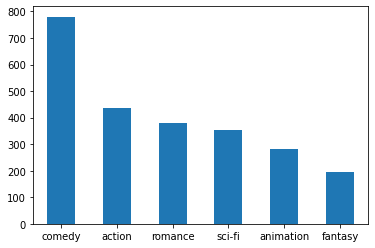

In [17]:
%matplotlib inline
import nltk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('data/tagged_plots_movielens.csv')
df = df.dropna()

print(df.head())
df.tag.value_counts().plot(kind="bar", rot=0)

Szybko dzielimy dane na zbiór uczący i testowy:

In [18]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)

Tokenizujemy dane i wyliczamy reprezentację wektorową (za pomocą zsumowanych wektorów słów wrod2vec):

In [19]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['plot']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['plot']), axis=1).values
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

Uczymy i testujemy klasyfikator:

In [20]:
logreg = LogisticRegression(n_jobs=-1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_data['tag'])
predicted = logreg.predict(X_test_word_average)

Patrzymy jak nam poszło:

In [21]:
print('Trafność klasyfikacji %s' % accuracy_score(test_data.tag, predicted))
cm = confusion_matrix(test_data.tag, predicted)
print('Macierz pomyłek\n %s' % cm)

Trafność klasyfikacji 0.5267489711934157
Macierz pomyłek
 [[23  2 11  1  2  3]
 [ 3  8  8  5  4  3]
 [ 4  4 56  2 16  4]
 [ 2  2  4  6  1  1]
 [ 3  1 14  1 14  2]
 [ 5  0  3  1  3 21]]


Jak na brak porządnego przetwarzania wstępnego, nie jest to zły wynik. Mam nadzieję, że ten przykład pokazał jak można wykorzystać word2vec do tworzenia atrybutów dla problemów klasyfikacyjnych.